<a href="https://colab.research.google.com/github/Wimmics/kgstat/blob/main/KG_and_Regression_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing descriptive statistics and applying regression models to meteorological data knowledge graph WeKG-MF.
#### maintained by the [WIMMICS team](https://team.inria.fr/wimmics/)

This notebook demonstrates how to access and query WeKG-MF RDF dataset. In this notebook we are going to visualize descriptive statistics and explore dependencies and correlations between the weather measurements.

The WeKG-MF dataset offers access to a large set of meteorological variables described through spatial and temporal dimensions.

The full description of the dataset can be found here: https://github.com/Wimmics/weather-kg/tree/main/meteo.

SPARQL query endpoint: http://weakg.i3s.unice.fr/sparql.

NOTE: Although this notebook closely resembles the [notebook in R](./KG_and_Regression_R.ipynb) it does not produce exactly the same results. This is due to the data updates and the difference in the default parameters of the models used by R and Python packages.

**REFERENCES:**

Nadia Yacoubi Ayadi, Catherine Faron, Franck Michel, Fabien Gandon, Olivier Corby. WeKG-MF: a Knowledge Graph of Observational Weather Data. ESWC 2022 - 19th Extended Semantic Web Conference, May 2022, Hersonissos, Greece. https://hal.inria.fr/hal-03657694/file/WeKG-MF-Poster-ESWC-2022.pdf


## Setup

If this notebook is running in Google Colab then some packages have to be installed every time the runtime is connected.

If this notebook is running on the local runtime then the packages have to be installed only once with `pip` or `conda` depending on the local distribution.

In [8]:
import sys
print(sys.version_info)

colab = 'google.colab' in sys.modules
if colab:
  import google.colab
  print(f"Google Colab Version: {google.colab.__version__}")

import os
conda = os.environ.get('CONDA_DEFAULT_ENV')

if conda:
  print(f'The runtime {conda} environment is a Conda distribution')

sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
Google Colab Version: 0.0.1a2


### Enabling querying of the Knowledge Graph  
The easiest way to access and query the dataset endpoint is to use the `SPARQLWrapper` package.

In [ ]:
if conda:
    !conda install conda-forge::sparqlwrapper
else:
    !pip install SPARQLWrapper

#### Define dataset endpoint for the SPARQL data access

NOTE: depending on the runtime environment an *https* endpoint URL may lead to an error. In this case, try to change it to *http*.

In [1]:
endpoint = 'http://weakg.i3s.unice.fr/sparql'

#### Define prefixes to abbreviate namespaces

In [11]:
sparql_prefix = '''
PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#>
PREFIX dct:  <http://purl.org/dc/terms/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX qb:   <http://purl.org/linked-data/cube#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX geo:  <http://www.w3.org/2003/01/geo/wgs84_pos#>

PREFIX weo:  <http://ns.inria.fr/meteo/ontology/>
PREFIX wep:  <http://ns.inria.fr/meteo/ontology/property/>
PREFIX wevp: <http://ns.inria.fr/meteo/vocab/weatherproperty/>

PREFIX wes-dimension: <http://ns.inria.fr/meteo/observationslice/dimension#>
PREFIX wes-measure:   <http://ns.inria.fr/meteo/observationslice/measure#>
PREFIX wes-attribute: <http://ns.inria.fr/meteo/observationslice/attribute#>

# returned data prefixes
PREFIX qudtu: <http://qudt.org/vocab/unit/>
PREFIX wd:    <http://www.wikidata.org/entity/>
PREFIX wdt:   <http://www.wikidata.org/prop/direct/>
PREFIX wes:   <http://ns.inria.fr/meteo/weatherstation/>
'''
#sparql_prefix = sparql_prefix.replace('< ', '<')
#sparql_prefix = sparql_prefix.replace(" >", ">")

#### Define helper function

In [12]:
from SPARQLWrapper import get_sparql_dataframe

import re
def parse_prefixes(prefix_string):
    pattern = re.compile(r'PREFIX\s+(\w+):\s+<\s*(.*?)\s*>')
    matches = pattern.findall(prefix_string)
    prefixes = {prefix + ':' : url for prefix, url in matches}
    return prefixes

def prefix_namespaces(df, ns):
    if ns and isinstance(ns, dict):
        return df.replace(ns.values(), ns.keys(), regex=True)
    return df

def sparql_service_to_dataframe(endpoint, query, dtypes=None):
    df = get_sparql_dataframe(endpoint, query)
    if dtypes:
      df = df.astype(dtypes, errors='ignore')

    return df

### Enabling visualization tools

For charting the data we will be using packages:
- `matplotlib` - generates plots, histograms, bar charts, errorcharts, scatterplots, etc., with just a few lines of code
- `seaborn` - data visualization library based on matplotlib thatbprovides a high-level interface for drawing attractive and informative statistical graphics
- `basemap` - the matplotlib basemap toolkit is a library for plotting 2D data on maps
- `folium` - makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map
- `squarify` - Python implementation of the treemap layout algorithm

NOTE: `matplotlib` and `seaborn` usually come with Python distribution (at least it's true for Google Colab runtimes). If this is not the case install the me using either by runnng  `pip install matplotlib seaborn` or `conda install matplotlib seaborn`.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
#TODO: use importlib.util.find_spec to chcek for th einstaleed packages
from  importlib.util import find_spec

find_spec('pandas')

ModuleSpec(name='pandas', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7e5472192e90>, origin='/usr/local/lib/python3.10/dist-packages/pandas/__init__.py', submodule_search_locations=['/usr/local/lib/python3.10/dist-packages/pandas'])

In [15]:
if conda:
  !conda install -y conda-forge::basemap
else:
  !pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.8/935.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 45.3 MB/s eta 0:00:00


In [16]:
if conda:
  !conda install -y conda-forge::folium
else:
  !pip install folium

In [17]:
if conda:
  !conda install -y conda-forge::squarify
else:
  !pip install squarify

### Enabling the Mchine Learning tools

In this notebook we demonstrate regression models provided by [scikit-learn](https://scikit-learn.org/stable/index.html) - simple and defficient tools for predictive analysis.

In [18]:
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

# Using for verification (remove at the end)
import statsmodels.api as sm

### Enabling data manipulation tools

For easy manipulations of data we use packages:
- `pandas` - most commonly used package for data wrangling and data manipulation
- `numpy` - support for multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
- `skrub` - we'll try to use this new package that facilitates preparing tables for machine learning

NOTE: `pandas` and `numpy` are usually preinstalled.

In [19]:
import pandas as pd
import numpy as np

In [20]:
if conda:
  !conda install conda-forge::skrub
else:
  !pip install skrub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 3.5 MB/s eta 0:00:00


In [21]:
# Define a helper function that adds missing data counts and datatypes to the
# pandas DataFrame description
def summary(df):
  return pd.concat( [df.describe(include = 'all'),
                     df.isna().sum(axis=0).to_frame().transpose().set_index( pd.Index(['NaNs'] )),
                     df.dtypes.to_frame().transpose().set_index( pd.Index(['Dtypes'] ))])


The setup is done.

## Visualizing weather stations locations
The dataset has information about the location of all the weather stations in France and overseas territories. Let's query the dataset for the list of French weather stations, their geographical coordinates, and administrative regions.

In [22]:
query_stations = '''
# wdt:P131 = located in the administrative territorial entity
# wdt:P2585 = INSEE region code

SELECT distinct STR(?regionLabel) as ?region
                ?station ?stationName
                ?lat ?long
WHERE {
        ?station  a weo:WeatherStation;
                  rdfs:label ?stationName;
                  geo:lat ?lat; geo:long ?long.

         OPTIONAL {?station dct:spatial/wdt:P131 ?region.
                   ?region rdfs:label ?regionLabel;
                           wdt:P2585 ?regionCode.}
}
ORDER BY ?regionCode ?stationName
'''

query_stations = '\n'.join([sparql_prefix, query_stations])

stations_df = sparql_service_to_dataframe(endpoint,
              query = query_stations,
              dtypes= {'lat': 'float', 'long': 'float'} )

#stations_df = prefix_namespaces(stations_df, parse_prefixes(sparql_prefix) )

### World map

First, we visualize all of the France Meteo stations in the world using `basemap` package.

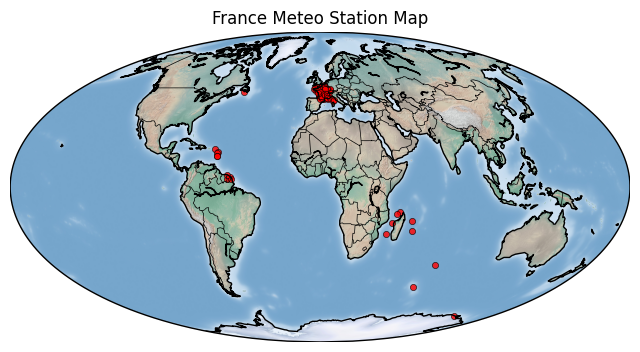

In [25]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(8, 5))

world_map = Basemap(projection='moll', lon_0=0, resolution='c')

# Plot the base map
world_map.drawcoastlines()
world_map.drawcountries()
world_map.shadedrelief()

# Plot points on the map
x, y = world_map(stations_df.long, stations_df.lat )
world_map.scatter (x, y, s=20,
                   color='red', marker='o' , alpha=0.8,
                    edgecolor='black',
                    linewidths=0.5)

#TODO: spread the lables
# Annotate points with station names
#for i, row in stations_df[stations_df.metropole == False].iterrows():
#    plt.annotate(row.stationName, (x[i], y[i]),
#                  textcoords="offset points", xytext=(0,10),
#                  ha='center', fontsize=6, fontweight='bold' )

plt.title("France Meteo Station Map")
plt.show()

# delete the map object as it might be pretty large
del world_map

#TODO: check out the warning

It appears that France Meteo has weather stations around the world.

### Metropolitan France map

Let's zoom in Metropolitan France which comprises mainland France and Corsica, as well as nearby islands in the Atlantic Ocean. This time we will use the `folium` package.

In [29]:
# Set up boundaries of the metroplitan France that can be used
# in rendering the maps
from collections import namedtuple

boundaries = namedtuple('boundaries', ['left', 'right', 'bottom', 'top'])
metropolitan_boundaries = boundaries(left =-5.4534286, right=9.8678344,
                                  bottom=41.2632185, top=51.268318 )

stations_df['metropole'] =  stations_df.apply(lambda row: row.long >= metropolitan_boundaries.left and\
                                                          row.long <= metropolitan_boundaries.right and\
                                                          row.lat >=  metropolitan_boundaries.bottom and\
                                                          row.lat <=  metropolitan_boundaries.top, axis=1)

In [32]:
import folium
from folium import plugins

plt.figure(figsize=(8,5))

center_lat = (metropolitan_boundaries.bottom + metropolitan_boundaries.top) / 2
center_lon = (metropolitan_boundaries.left + metropolitan_boundaries.right) / 2

# Create a map of France with specified boundaries
france_map = folium.Map(location=[center_lat, center_lon],
                        min_zoom=5, max_zoom=5,
                        zoom_control=False, scrollWheelZoom=False,
                        width='60%', height='60%',
                        min_lat = metropolitan_boundaries.bottom, max_lat=metropolitan_boundaries.top,
                        min_lon = metropolitan_boundaries.left, max_lon=metropolitan_boundaries.right,
                        max_bounds=True,
                        tile='CartoDB Positron',
                        )

for index, row in stations_df[stations_df.metropole == True].iterrows():
    folium.Marker([row.lat, row.long],
                  popup=row.stationName,
                  icon=folium.Icon(icon='cloud', color='blue')).add_to(france_map)

france_map

<Figure size 800x500 with 0 Axes>

## Exploring data from a weather station

Query the amount of available data for a selected station. This might be useful in deciding which weather properties we can analyze.


In [33]:
station_name = "NICE"

In [34]:
query_properties = f'''
SELECT ?prop  (MIN(?result) AS ?min_value)
              (MAX(?result) AS ?max_value)
              (AVG(?result) AS ?avg_value)
              (SAMPLE(?prop_unit) AS ?unit)
              (MIN(?time) AS ?min_time)
              (MAX(?time) AS ?max_time)
              (COUNT(DISTINCT ?obs) AS ?datapoints_count)
              (COUNT(DISTINCT ?date) AS ?days_count)
              (COUNT(DISTINCT ?year) AS ?years_count)
              (GROUP_CONCAT(DISTINCT ?interval; SEPARATOR=", ") AS ?intervals)

WHERE {{
    VALUES (?stationName) {{('{station_name}')}}
    ?stationIRI rdfs:label ?stationName.

    ?obs a weo:MeteorologicalObservation;
          wep:madeByStation  ?stationIRI;
          sosa:observedProperty ?prop ;
          sosa:resultTime ?time ;
          sosa:hasSimpleResult ?result .

     OPTIONAL {{ ?prop skos:prefLabel ?propLabel.}}

     OPTIONAL {{ ?obs sosa:phenomenonTime [ a ?interval ]. }}
     OPTIONAL {{?prop qudt:applicableUnit ?prop_unit. }}

     BIND(xsd:date(SUBSTR(STR(?time), 1,10)) AS ?date )
     BIND(YEAR(?time) AS ?year )
}}
GROUP BY ?prop
'''

query_properties = '\n'.join([sparql_prefix, query_properties])

weather_props = sparql_service_to_dataframe(endpoint,
                                            query = query_properties,
                                            dtypes={'min_value': 'float',
                                                    'max_value': 'float',
                                                    'avg_value': 'float',
                                                    'min_time': 'datetime64[ns]',
                                                    'max_time': 'datetime64[ns]',
                                                    'datapoints_count' : 'int',
                                                    'days_count' : 'int',
                                                    'years_count' : 'int' })

#TODO: strip namespaces
weather_props.shape

(18, 11)

### Visualize the number of observations per weather property

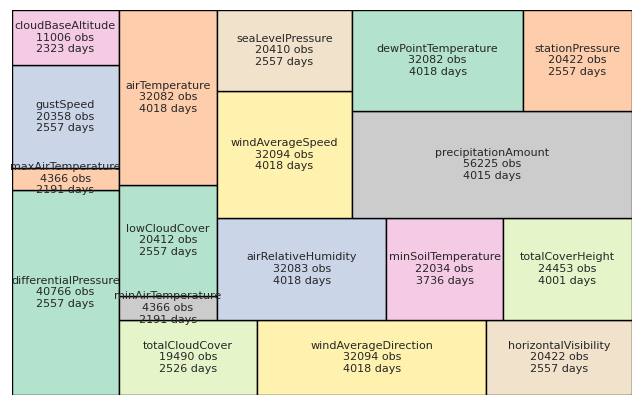

In [36]:
import squarify

plt.figure(figsize=(8, 5))
sns.set_theme()

cmap = plt.get_cmap("Pastel2")
colors =[cmap(i % len(cmap.colors)) for i in range(weather_props.shape[0])]

# Create labels
def treemap_label(row):
  prop_name = row.prop.split('/')[-1]
  return f'{prop_name}\n{row.datapoints_count} obs\n{row.days_count} days'

labels = weather_props.apply(treemap_label , axis=1)

squarify.plot(sizes= weather_props.datapoints_count,
              label= labels,
              edgecolor='black',
              color=colors,
              #pad=True,
              text_kwargs = {'fontsize': 8}
              )
#TODO: improve the lable size
plt.axis("off")
plt.show()

OBSERVATIONS AND CONCLUSIONS

---


- half of the observations are taken 8 times a day (every 3 hours) during 4018 days (11 years)
- 2 properties *minAirTemperature* and *maxAirTemperature* are the aggregates, however there is a mismatch between the number of days and minimum and maximum temperatures. Need to investigate.  
-  properties *cloudBaseAltitude*, *totalCloudCover*, *lowCloudCover*, *horisontalVisibility*, *seaLevelPressure*, *stationPressure*, *gustSpeed*, *minSoilTemperature*  are missing  more than 10 days of observations
- 2 properties *percipitationAmount* and *diffrentialPressure* observations are recorded twice at the same time and represent cumulative values or differences respectively for 3 hours and 12 hours.


### Visualize the range of values  for each weather property

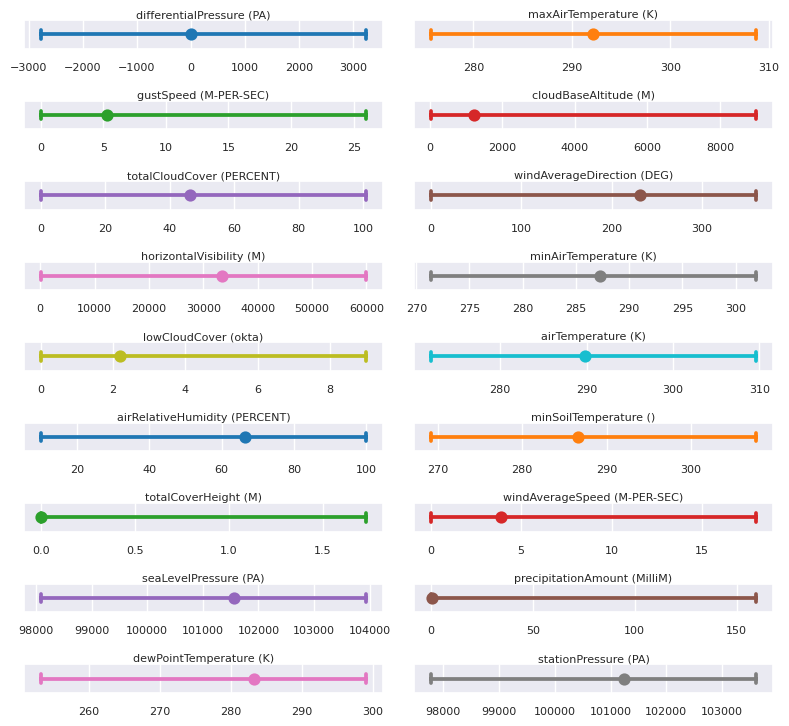

In [37]:
plt.figure(figsize=(8, 8))
sns.set_theme()

def plot_range(avg, min, max, color=None, **kws):
    sns.pointplot(x=[avg] * 10,
                  errorbar=lambda x: (min,max),
                  capsize=.3,
                  color=color,
                  native_scale=True,
                  **kws )

def range_title(row):
  row = row.fillna('')
  prop_name = row.prop.split('/')[-1]
  unit = row.unit.split('/')[-1]
  return f'{prop_name} ({unit})'

# Arrange colors
cmap = plt.get_cmap("tab10")
colors =[cmap(i % len(cmap.colors)) for i in range(weather_props.shape[0])]

# Create titles
titles = weather_props.apply(range_title, axis=1)

# Claculate the number of rows needed to plot all properties
plot_rows = weather_props.shape[0] // 2 + 1

for i, row in weather_props.iterrows():
  plt.subplot(plot_rows,2, i+1 )

  plot_range(row.avg_value, row.min_value, row.max_value,
             color=colors[i] )

  plt.title(titles[i] , fontsize=8, pad=2 )
  plt.xticks(fontsize=8)


plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

## Hypothesis Testing with Linear Regression

Intuitively we assume that air temperature might be dependent on other weather factors like relative humidity or/and wind speed. We can test this hypothesis (or rather the null hypothesis that there is no significant relationship) by trying to detect a linear relationship between *airTemperature* and *airRelativeHumidity* and/or *windAverageSpeed*.  

### Query values for selected weather properties

The data server returns a maximum of 50,000 rows of data so we cannot request all the data at once. We can either
- use a loop with LIMIT and OFFSET clauses (not discussed here) or
- take one year of measurements using FROM to restrict queriable graphs (current query) or
- or we can get as much data as we can from the beginning of the observation time (comment FROM clauses)

In [38]:
query_weather_data = f'''
SELECT ?prop  ?time ?value

FROM <http://ns.inria.fr/meteo/observation/2016>
FROM <http://ns.inria.fr/meteo/weatherstation>

WHERE {{
    VALUES (?stationName) {{('{station_name}')}}
    VALUES (?prop) {{ ( wevp:airTemperature )
                     #( wevp:airRelativeHumidity )
                     ( wevp:windAverageSpeed ) }}
    ?stationIRI rdfs:label ?stationName.

    ?obs a weo:MeteorologicalObservation;
          wep:madeByStation  ?stationIRI;
          sosa:observedProperty ?prop ;
          sosa:resultTime ?time ;
          sosa:hasSimpleResult ?value.

     BIND(xsd:date(SUBSTR(STR(?time), 1,10)) AS ?date )
     BIND(YEAR(?time) AS ?year )
}}
ORDER BY ?time
'''
#query_weather_data = query_weather_data.replace('< ', '<')
#query_weather_data = query_weather_data.replace(' >', '>')
query_weather_data = '\n'.join([sparql_prefix, query_weather_data])

weather_data = sparql_service_to_dataframe(endpoint,
                                            query = query_weather_data,
                                            dtypes={'time': 'datetime64[ns]',
                                                    'value': 'float' })


# remove prefix from the property names to make life easier
# when property names will become column names
weather_data.prop = weather_data.prop.apply(lambda x: x.split('/')[-1])

weather_data.shape

(5839, 3)

We want to have the data points for each weather property aligned on the time scale. We can take advantage of *wide* time series format, where each row represents a time point with all the weather properties values. As opposed to the *long* format where each value has a row like a result of the query.

In [39]:
weather_data_wide = weather_data.pivot(index='time', columns='prop', values='value' ).reset_index()

summary(weather_data_wide)

<ipython-input-21-02d2d87b52f2>:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  return pd.concat( [df.describe(include = 'all'),


prop,time,airTemperature,windAverageSpeed
count,2922,2917.0,2922.0
unique,2922,NaN,NaN
top,2016-01-01 00:00:00,NaN,NaN
freq,1,NaN,NaN
first,2016-01-01 00:00:00,NaN,NaN
last,2016-12-31 21:00:00,NaN,NaN
mean,NaN,289.752605,4.040281
std,NaN,6.050987,2.349862
min,NaN,276.25,0.0
25%,NaN,284.95,2.5


### Handle missing values
Perhaps not all of the time points have all the weather property values. We can identify them and if there are only a few we can drop them.

In [40]:
print("MISSING VALUES")

print(weather_data_wide.loc[weather_data_wide.isna().sum(axis=1) == True])

# Drop missing values
weather_data_wide.dropna(inplace=True)

weather_data_wide.shape

MISSING VALUES
prop                time  airTemperature  windAverageSpeed
392  2016-02-19 00:00:00             NaN               4.0
444  2016-02-25 12:00:00             NaN               2.4
445  2016-02-25 15:00:00             NaN               5.0
2613 2016-11-23 09:00:00             NaN              12.7
2614 2016-11-23 12:00:00             NaN              14.2


(2917, 3)

### Handle outliers

Outliers increase the variability in the data, which decreases statistical power. Some outliers represent natural variations in the measurements, and they should be left in the dataset. These are called true outliers. Other outliers can represent measurement errors, data entry or processing errors, or poor sampling and should be removed from the dataset.

For example, intuitively we know that a strong wind is a rear event in many parts of France and is not representative of normal weather.

For simplicity reasons, we can remove all of the outliers using the interquartile range method provided by ```boxplot``` functionality.

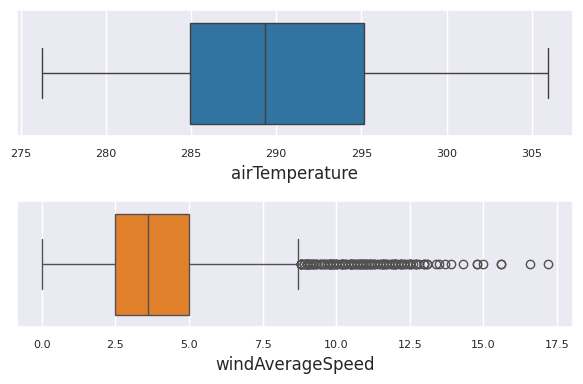

In [41]:
plt.figure(figsize=(6,4))
sns.set_theme()

plot_rows = weather_data_wide.select_dtypes('float64').columns.shape[0]

for i, prop in enumerate(weather_data_wide.select_dtypes('float64').columns):
  plt.subplot(plot_rows, 1, i+1)
  sns.boxplot(data=weather_data_wide,
              x = prop,
              color=colors[i])
  plt.xticks(fontsize=8)

plt.tight_layout()
plt.show()
# TODO: try to pivot the dataframe and do it on one plot

We can see that temperature data does not have any outliers but the wind speed data contains quite a few.

We can use Inter-Quartile Range [IRQ](https://en.wikipedia.org/wiki/Interquartile_range) method for outlier detection (the same is used in the R's boxplot). We could not find off-the-shelf  implementation of this method in Python. But it isn't hard to do.

In [42]:
Q1 = weather_data_wide.windAverageSpeed.quantile(0.25)
Q3 = weather_data_wide.windAverageSpeed.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = weather_data_wide[(weather_data_wide.windAverageSpeed < Q1 - 1.5 * IQR) | \
                             (weather_data_wide.windAverageSpeed > Q3 + 1.5 * IQR)]

#TODO: mark outliers instaed
print('Dropping ', outliers.index.shape[0], ' outliers')

weather_data_wide.drop( outliers.index, axis = 0, inplace=True)
weather_data_wide.shape

Dropping  151  outliers


(2766, 3)

In [43]:
# TODO: try something more interesting with sklearn for outlier detection
# https://scikit-learn.org/stable/modules/outlier_detection.html#id1
from sklearn.preprocessing import QuantileTransformer, RobustScaler, robust_scale
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

### Simple linear regression

Let's build a linear regression model to check out our intuition that there is a relationsip between `airTemperature` and `windAverageSpeed`.

TODO: choose the visualization

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

X = weather_data_wide.windAverageSpeed.to_frame()
y = weather_data_wide.airTemperature

lr = LinearRegression(fit_intercept=True)
lr.fit(X, y)

#TODO: use f-strings with formatting
print('Regression coefficients:', lr.coef_[0], lr.intercept_)
print(f'R2: {lr.score(X,y):.3f}' )

f_statistics, p_value =f_regression(X,y, )

print('p-value:', p_value)

# Calculate adjusted R-squared # delete because it does not make sense to do in univariate regression
adj_r_squared = 1 - (1 - lr.score(X, y)) * (len(y) - 1) / (len(y) - X.shape[1] - 1)
print('Adj R square score:', adj_r_squared)

Regression coefficients: -1.0034694794313952 293.44254616128507
R2: 0.077
p-value: [8.32316532e-50]
Adj R square score: 0.07624393887164349


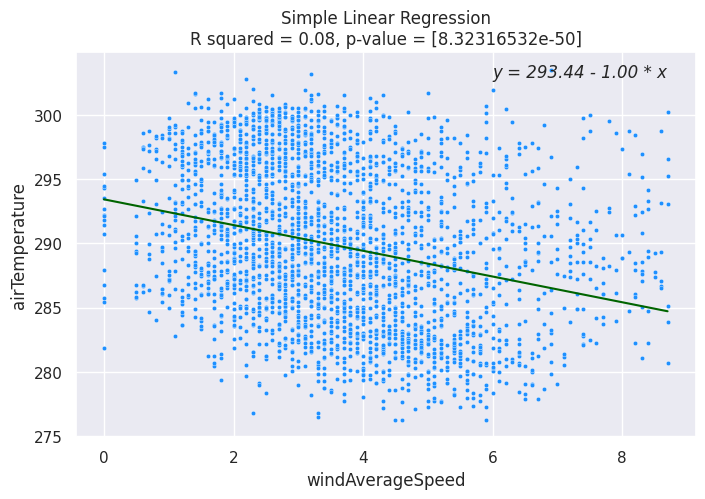

In [46]:
plt.figure(figsize=(8,5))
sns.set_theme()

lr_title=f'Simple Linear Regression\nR squared = {lr.score(X,y):.2f}, p-value = {p_value}'
sign = '+' if lr.coef_[0] >= 0 else '-'
lr_formula = f"y = {lr.intercept_:.2f} {sign} {abs(lr.coef_[0]):.2f} * x"

sns.scatterplot(x=weather_data_wide.windAverageSpeed,
                y=weather_data_wide.airTemperature,
                color='dodgerblue',s=10)

x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_line = lr.intercept_ + lr.coef_[0] * x_line
plt.plot(x_line,  y_line, color='darkgreen')

plt.text(6, 303,  lr_formula,
         size=12, fontstyle='italic')
plt.title(lr_title)

plt.show()
#TODO: add confidence interval: sns.lineplot

We can visualize the linear regression with `seaborn.regplot` function without even running the linear regression ourselves. For the record the `seaborn.regplot` uses `statsmodels` package to run the regression.

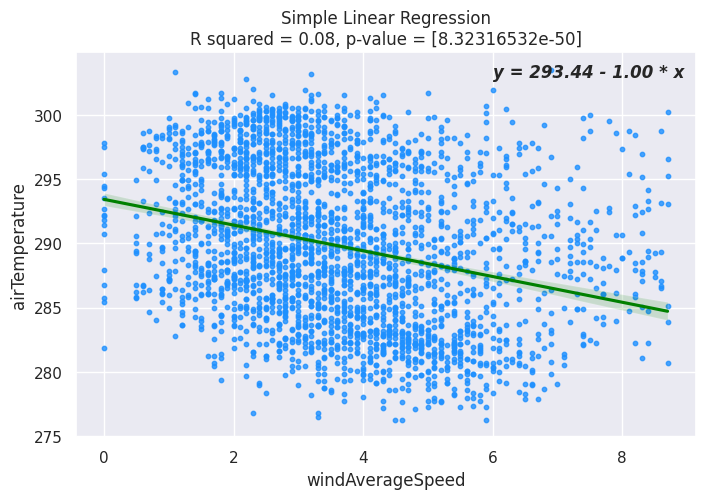

In [47]:
plt.figure(figsize=(8,5))
sns.set_theme()

sns.regplot(x=weather_data_wide.windAverageSpeed,
            y=weather_data_wide.airTemperature,
            color='dodgerblue',
            ci=95,
            scatter_kws={'s': 10},
            line_kws={'color': 'green'})

plt.text(6, 303, lr_formula,
         size=12, fontstyle='italic', fontweight='bold')
plt.title(lr_title)

plt.show()

OBSERVATIONS AND CONCLUSIONS:

---

We built a Linear Regression with and without removing outliers. We found a significant relationship between `airTemperature` and `windAverageSpeed` in both cases with p-value << 0.001. However, removing outliers shows a stronger effect of wind speed  on the temperature.

- with outliers: ~ 0.5 degrees decrease in air temperature for every 1 m/sec increase of wind speed
- without outliers: ~ 1.0 degree decrease in air temperature for every 1 m/sec increase of wind speed
- the coefficient of determination (R2) is a low 0.08 which means that wind speed can explain only 8% of the variance in the air temperature values.

This corresponds to our common sense knowledge that the weather is a complex system and the temperature depends on many more weather factors.



---



### Model evaluation
Let's see if this linear model works well to describe the relationship between `windAverageSpeed` and `airTemperature` and meets the assumptions of linear regression.

For univariate LR the data should meet the following assumptions: linearity of the data, normality of residuals, and homogeneity of residuals variance (homoscedasticity)

| Assumption          | Plot              | What should we see |
| :----               | :----             | :---       |
| __Linearity__       |Residual vs. Fitted| There should be a straight red line close to 0.|
| __Normality__       |Normal Q-Q         | The normal probability plot of residuals should approximately follow a straight line.|
| __Homoscedasticity__|Scale-Location     | The residuals should be equally spread along a horizontal red line.  |


The fourth _Residuals vs Leverage_ plot can help to detect the outliers. Look for the points that are above and below 3 standard deviations on this plot.  

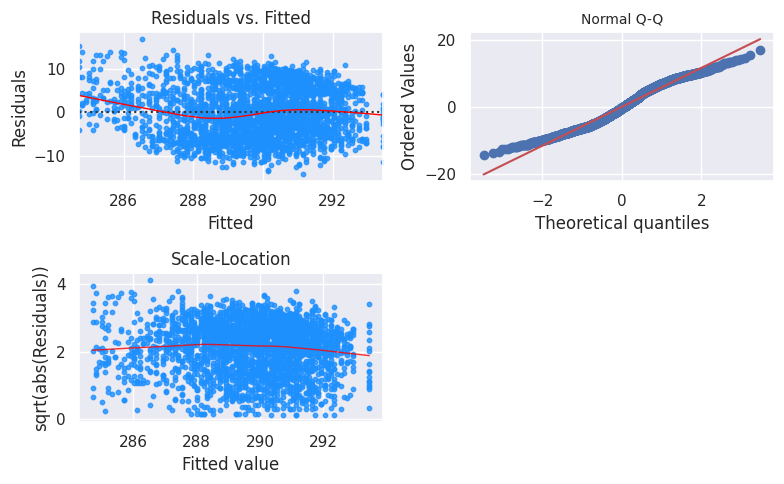

In [48]:
import scipy.stats as stats

plt.figure(figsize=(8,5))
sns.set_theme()

# Plot Residuals vs. Fitted
y_pred = lr.predict(X)
residuals = y - y_pred

plt.subplot(2, 2, 1)
sns.residplot(x=y_pred,
              y=residuals,
              lowess=True,
              scatter_kws= {'color' : 'dodgerblue', 's':10 },
              line_kws={'color': 'red', 'lw': 1, 'alpha': 1})

plt.title('Residuals vs. Fitted')
plt.xlabel('Fitted')
plt.ylabel('Residuals')

# Plot Normal Q-Q
plt.subplot(2, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q', fontsize=10)

# Plot Scale-Location
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.subplot(2, 2, 3)
sns.regplot(x=y_pred,
            y=model_norm_residuals_abs_sqrt,
            scatter=True,
            lowess=True,
            scatter_kws= {'color' : 'dodgerblue', 's':10 },
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Scale-Location')
plt.ylabel('sqrt(abs(Residuals))')
plt.xlabel('Fitted value')

#TODO: figure out how to plot 'Residuals vs. Leverage'
# bit it is not absolutely nesessary as we don't use this plot

plt.tight_layout()
plt.show()

#TODO: work on fontsize to make the plots look prettier

OBSERVATIONS AND CONCLUSIONS

---

By looking at the diagnostics plot, we can see that our regression model meets the linear regression assumptions.

- __[x] Linearity of the data__
- __[x] Normality of residuals__
- __[x] Homoscedasticity__

## Variable selection and multivariate regression

As we can see, one weather factor cannot explain the temperature variation. The WeKG contains many weather properties collected over the years. We can try discovering what other weather factors may influence the air temperature.

The idea of variable selection is to find the "best" set of weather properties that can be used to estimate the air temperature.  

### Query data for all weather properties for one year

At first, we query the wether properties values for 2016
- excluding aggregated properties *minAirTemperature* and *maxAirTemperature*
- excluding *cloudBaseAltidude* and *totalCloudCover* that do not have enough observations
- excluding measurements cumulative/differential observations over 12 hours in the cases of *percipitationAmount* and *differentialPressure*.

See the tree map above.

We use FROM clause to select data only from 2016
We use FILTER clause of the SPARQL query to exclude properties

In [49]:
query_all_properties_data = f'''
SELECT ?prop
       ?time
       ?value

FROM <http://ns.inria.fr/meteo/observation/2016>
FROM <http://ns.inria.fr/meteo/weatherstation>

WHERE {{
     VALUES (?stationName) {{ ("{station_name}") }}

    ?stationIRI rdfs:label ?stationName.

    ?obs a weo:MeteorologicalObservation;
          wep:madeByStation  ?stationIRI;
          sosa:observedProperty ?prop ;
          sosa:resultTime ?time ;
          sosa:hasSimpleResult ?value.

     OPTIONAL {{ ?obs sosa:phenomenonTime [ a ?interval ]. }}

     FILTER (?prop NOT IN (wevp:minAirTemperature, wevp:maxAirTemperature,
                           wevp:cloudBaseAltitude, wevp:totalCloudCover) )

     FILTER (?interval != weo:Interval24h || !BOUND(?interval) )

}}
ORDER BY ?time ?prop ?value
'''
#query_all_properties_data = query_all_properties_data.replace('< ', '<')
#query_all_properties_data = query_all_properties_data.replace(' >', '>')
query_all_properties_data = '\n'.join([sparql_prefix, query_all_properties_data])

weather_data_all = sparql_service_to_dataframe(endpoint,
                                                query = query_all_properties_data,
                                                dtypes={'time': 'datetime64[ns]',
                                                        'value': 'float' })

# TODO: switch to using Skrub.to_datetime

# remove prefix from the property names to make life easier
# when property names will become column names
weather_data_all.prop = weather_data_all.prop.apply(lambda x: x.split('/')[-1])

weather_data_all.shape

(40731, 3)

### Data wrangling

We will perform some basic data manipulations like excluding duplicates, outliers, and missing values.

In [50]:
#TODO: add faceted boxplot

In [51]:
drop_duplicates = True
drop_missing = True
drop_outliers = True
replace_outliers = False
remove_constants = True

print('Original data shape:', weather_data_all.shape)

if drop_duplicates:
  weather_data_all.drop_duplicates(subset=['time', 'prop'], inplace=True)
  print('Deduplicated shape:', weather_data_all.shape)

# Convert to wide format
weather_data_all_wide = weather_data_all.pivot(index='time', columns='prop', values='value' ).reset_index()

print('Wide format data shape:',  weather_data_all_wide.shape)

if drop_missing:
  weather_data_all_wide.dropna(inplace=True)
  print(f'Missing values removed, new shape: {weather_data_all_wide.shape}' )

#TODO: possibly improve with scikit-learn or write an explanation of z-score
#based outlier detection
if drop_outliers:
  from scipy import stats
  cols = list(weather_data_all_wide.drop(columns='time').columns)
  # Calculate z-score
  z_scores = np.abs(stats.zscore(weather_data_all_wide[cols]))
  # Remove rows with z-score > 3 (0.3%)
  outlier_mask = np.any(z_scores > 3, axis=1)
  # Save outliers rows for analysis
  weather_data_outliers = weather_data_all_wide[outlier_mask]
  weather_data_all_wide.drop(axis=0, index=weather_data_outliers.index, inplace=True)
  print(f'Outliers removed {outlier_mask.sum()}, new shape: {weather_data_all_wide.shape}' )

if replace_outliers:
  from scipy import stats
  cols = list(weather_data_all_wide.drop(columns='time').columns)
  z_scores = np.abs(stats.zscore(weather_data_all_wide[cols]))
  #finish

if remove_constants:
  descr = weather_data_all_wide.describe().transpose()
  cols = descr[descr['min'] == descr['max'] ].index.to_list()
  weather_data_all_wide.drop(axis=1, columns=cols, inplace=True)
  print(f'Replaced columns {cols}, new shape: {weather_data_all_wide.shape}' )

Original data shape: (40731, 3)
Deduplicated shape: (40731, 3)
Wide format data shape: (2922, 15)
Missing values removed, new shape: (2826, 15)
Outliers removed 154, new shape: (2672, 15)
Replaced columns ['totalCoverHeight'], new shape: (2672, 14)


### Correlation analysis
Let's perform a correlation analysis of the weather properties to discover their pair-wise relationship and how strong this relationship may be.

We calculate the Pearson correlation coefficient (r), which measures a linear dependence between two variables. The rule of thumb for interpreting the strength of the relationship between two variables is based on the value of r:

> | Absolute value of r | Strength of relationship |
> | :----:              | :----                    |
> |        r < 0.25     | No relationship          |
> | 0.25 < r < 0.5      | Weak relationship        |
> | 0.5  < r < 0.75     | Moderate relationship    |
> | 0.75 < r            | Strong relationship      |



In [52]:
# Correlation is easy to calculate using pandas method
r = weather_data_all_wide.corr(method='pearson', numeric_only=True)

<Figure size 1000x600 with 0 Axes>

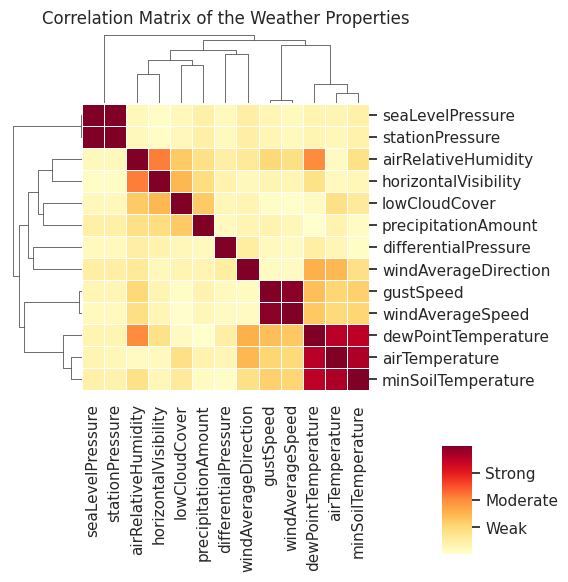

In [53]:
plt.figure(figsize=(10, 6))
sns.set_theme()

r_labels = ['No relationship', 'Weak', 'Moderate', 'Strong']
r_levels = [0.0, 0.25, 0.5, 0.75]

cm = sns.clustermap(np.abs(r), annot=False, cmap='YlOrRd', fmt=".2f",
               linewidths=0.5, figsize=(6,6),
               cbar_pos=(0.75, 0.1, 0.05, 0.18),
               cbar_kws={'ticks': r_levels} )

#cm.cax.set_visible(False)
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.set_ylabel('')
cm.ax_heatmap.set_title('Correlation Matrix of the Weather Properties', y=1.25)
cm.ax_cbar.set_yticklabels(labels=r_labels)

plt.show()

OBSERVATIONS AND CONCLUSIONS

---



From the heatmap of the correlation matrix we can tell that *airTemperature* has
- strong relationships with *minSoilTemperature* and *dewPointTemperature*
- weak relationships with *windAverageDirection*, *gustSpeed*, and *windAverageSpeed*
- we also see the obvious strong correlation between the wind speeds *windAverageSpeed* and *gustSpeed* however it is surprising to see a weak relationship between *airRealtiveHumidity* and wind speed
- we see the relation between visibility and cloud cover  
- we see the relation between the pressure properties

This shows us that in this set of properties if we want to do a linear regression to model one property dependency on another and if we choose to use all of the properties we will violate the fourth assumption of linear regression __independence__.

To build a good multivariate regression we need to select the independent variables (predictors).

### Feature selection with LASSO


The LASSO (Least Absolute Shrinkage and Selection Operator) model is used for the selection and reduction of parameters for regression. It can determine a minimal number of variables that gives the largest predictive power. This method helps to deal with _multicollinearity_.

We can use the 10-fold cross-validated LASSO to determine the best hyperparameter α (λ in R) and fit the LASSO regression. Then we can select the features that are more prominent.



In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

X = weather_data_all_wide.drop(columns=['time', 'airTemperature'])
y = weather_data_all_wide['airTemperature']
columns = X.columns

# Scale the feature and target variable
scaler = StandardScaler()
y = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()
scaler.set_output(transform="pandas")
X = scaler.fit_transform(X)

lasso = LassoCV(cv=10, fit_intercept=True).fit(X, y)

# Print the best alpha value
print(f'Best alpha: {lasso.alpha_:.3f}' )
print(f'R2 score  : {lasso.score(X, y):.3f}')

# Print the coefficients for the best alpha
lassoCV_s1_coefficients = pd.DataFrame({'feature': columns, 'coefficient': lasso.coef_ })
print("Coefficients for the best alpha:")
print(f'Intersept : {lasso.intercept_:.6f}' )
print(lassoCV_s1_coefficients)

Best alpha: 0.001
R2 score  : 0.995
Coefficients for the best alpha:
Intersept : 0.000000
                 feature  coefficient
0    airRelativeHumidity    -0.534647
1    dewPointTemperature     1.112438
2   differentialPressure    -0.000000
3              gustSpeed     0.000000
4   horizontalVisibility    -0.006028
5          lowCloudCover    -0.000000
6     minSoilTemperature     0.036497
7    precipitationAmount     0.010281
8       seaLevelPressure    -0.005749
9        stationPressure    -0.000000
10  windAverageDirection    -0.002821
11      windAverageSpeed    -0.004939


Also we can use *1 SE rule* to select even less features. The main point of the 1 SE rule, is to choose the optimal model whose accuracy is comparable with the best model but uses the mininmum features.

In [55]:
from sklearn.linear_model import Lasso

mse_path_mean = lasso.mse_path_.mean(axis=1)
lse = mse_path_mean.min() + mse_path_mean.std()/np.sqrt(mse_path_mean.shape[0])
lse_ind = np.abs(mse_path_mean - lse).argmin()
lasso_alpha_1se = lasso.alphas_[lse_ind]
lasso_alpha_1se

lasso_1se = Lasso(alpha=lasso_alpha_1se, fit_intercept=True).fit(X,y)

# Print the best alpha value
print(f'alpha@1SE : {lasso_alpha_1se:.3f}')
print(f'R2 score  : { lasso_1se.score(X, y):.3f}')

# Print the coefficients for the best alpha
lassoCV_s2_coefficients = pd.DataFrame({'feature': columns, 'coefficient': lasso_1se.coef_ })
print("Coefficients for the best alpha:")
print(f'Intersept : {lasso_1se.intercept_:.3f}')
print(lassoCV_s2_coefficients)

alpha@1SE : 0.068
R2 score  : 0.972
Coefficients for the best alpha:
Intersept : 0.000
                 feature  coefficient
0    airRelativeHumidity    -0.345439
1    dewPointTemperature     0.825298
2   differentialPressure    -0.000000
3              gustSpeed    -0.000000
4   horizontalVisibility     0.000000
5          lowCloudCover    -0.000000
6     minSoilTemperature     0.184145
7    precipitationAmount    -0.000000
8       seaLevelPressure    -0.000000
9        stationPressure    -0.000000
10  windAverageDirection    -0.000000
11      windAverageSpeed    -0.000000


We can plot the MSE for each fold to see how it depened on alpha.

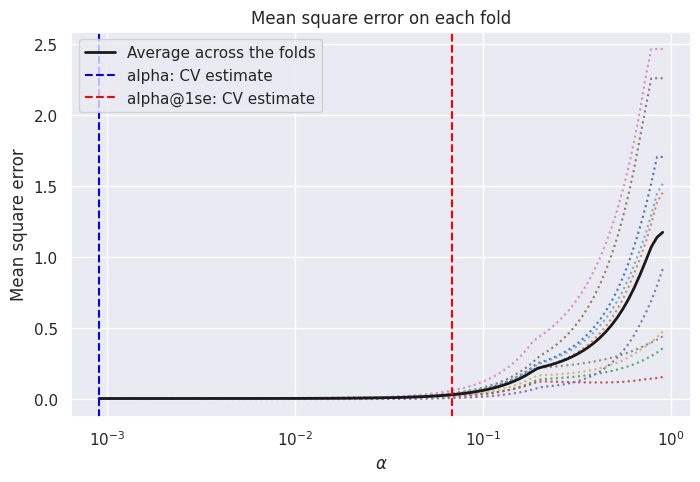

In [56]:
plt.figure(figsize=(8, 5))
sns.set_theme()

plt.semilogx(lasso.alphas_, lasso.mse_path_, ":")
plt.plot(lasso.alphas_ ,
        lasso.mse_path_.mean(axis=1),
        "k",
        label="Average across the folds",
        linewidth=2)

plt.axvline(lasso.alpha_, linestyle="--", color="blue",
            label="alpha: CV estimate")

plt.axvline(lasso_alpha_1se, linestyle="--", color="red",
            label="alpha@1se: CV estimate")

plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

plt.show()

OBSERVATIONS

---
We have two sets of feature selected by using LASSO model:

- the model that produced a minimum MSE with 8 variables with non-zero coefficients
- the model that produced MSE within 1 standard error with 3 non-zero variables

Now we can compare the regressions with different number of predictors by plotting the true values vs. predicted on the same plot.

We also calculate the Adjusted R-squared metrics on the unseen data because it accounts for the number of predictors included in each model. Unlike the standard R-squared, which tends to increase as more predictors are added, adjusted R-squared penalizes the inclusion of unnecessary predictors that do not significantly improve the model's performance.

In [57]:
input_features = { 'original'  : lassoCV_s1_coefficients.feature,
                   'lasso best': lassoCV_s1_coefficients.loc[abs(lassoCV_s1_coefficients.coefficient) > 0, 'feature'],
                   'lasso 1se' : lassoCV_s2_coefficients.loc[abs(lassoCV_s2_coefficients.coefficient) > 0, 'feature']}

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(weather_data_all_wide ,
                                                    weather_data_all_wide.airTemperature,
                                                    test_size=0.2, random_state=42,
                                                    )

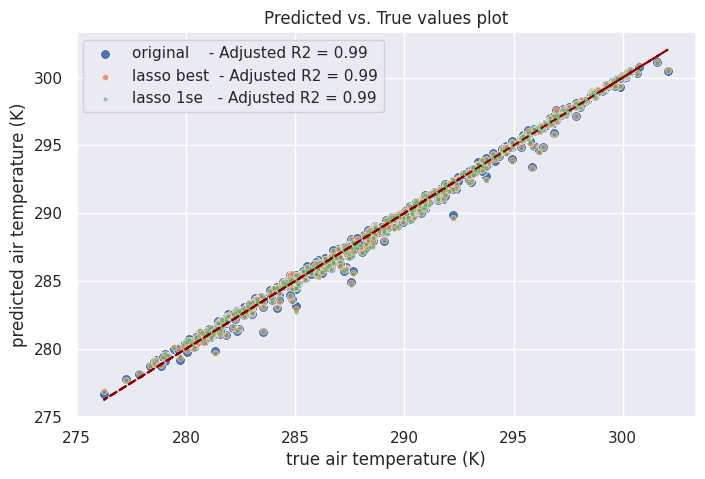

In [59]:
plt.figure(figsize=(8,5))
sns.set_theme()

#y = weather_data_all_wide.airTemperature

marker_styles = ['s', 'o', '^']
marker_sizes = [50, 20, 10]

for i, (name, features) in enumerate(input_features.items()):
  #X = weather_data_all_wide.loc[:, features.to_list()]
  X_train_ = X_train.loc[:, features.to_list()]
  X_test_ = X_test.loc[:, features.to_list()]

  lr_multi = LinearRegression(fit_intercept=True).fit(X_train_,y_train)
  y_pred = lr_multi.predict(X_test_)

  # R square
  r2 = lr_multi.score(X_test_,y_test)

  # Calculate adjusted R-squared
  n_features = len(features) + 1
  n_obs = y_test.shape[0]
  adjusted_r2 = 1 - ((1 - r2) * (n_obs - 1) / (n_obs - n_features - 1))

  sns.scatterplot(x=y_test,
                  y=y_pred,
                  label=f'{name:<12}- Adjusted R2 = {adjusted_r2:.2f}',
                  #marker=marker_styles[i],
                  s=marker_sizes[i],
                  alpha=1 - 0.2 * i)

plt.plot(y_test, y_test, color='darkred', linestyle='--', label='Perfect Prediction')

plt.title('Predicted vs. True values plot')
plt.xlabel('true air temperature (K)')
plt.ylabel('predicted air temperature (K)')

plt.show()

OBSERVATIONS AND CONCLUSIONS

---

From the plot above we can see that model of dependence of the `airTemperature` on the other meteorological measurement can be described with just 3 of 12 available featuers, `airRelativeHumidity`, `dewPointTemperature`, and `minSoilTemperature` and this model is as good as the other larger ones.